In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, json, joblib, time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
use_gpu=False
BASE = Path(".")
MODEL_DIR = BASE / "models"
PLOT_DIR = BASE / "plots"
MODEL_DIR.mkdir(exist_ok=True)
PLOT_DIR.mkdir(exist_ok=True)
SAVE_DIR=Path("models")

SEED = 42
np.random.seed(SEED)

In [ ]:
import os, json, joblib, time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# XGBoost and Keras
import xgboost as xgb
# from xgboost import callback as xgb_callback # Import xgb_callback - Not used if early_stopping_rounds is direct parameter
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks



def find_top_correlated_features(df, target_col='O3_target', top_n=70, save_path='top_features.json'):
    """
    Find top N features most correlated with target column FROM ENGINEERED FEATURES.
    Call this AFTER create_features() to select from all lag/roll features.

    Parameters:
    -----------
    df : DataFrame
        DataFrame with ALL engineered features (lags, rolls, etc.)
    target_col : str
        Name of target column (e.g., 'NO2_target' or 'O3_target')
    top_n : int
        Number of top correlated features to return
    save_path : str or Path
        Path to save the selected features as JSON

    Returns:
    --------
    dict : Dictionary with target_col as key and list of top features
    """

    df = df.copy()

    # Define columns to exclude from feature selection
    exclude_cols = {"year", "month", "day", "hour", "datetime", "day_of_week"}

    # Get all potential feature columns (exclude time columns and other targets)
    candidate_features = [
        c for c in df.columns
        if c not in exclude_cols
        and c != target_col
        and not (c.endswith("_target") and c != target_col)  # Exclude other targets
    ]

    # Check if target exists
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")

    # Calculate correlations
    correlations = {}
    for feature in candidate_features:
        if feature in df.columns:
            # Calculate correlation, handling NaN values
            valid_mask = df[feature].notna() & df[target_col].notna()
            if valid_mask.sum() > 0:
                corr = df.loc[valid_mask, feature].corr(df.loc[valid_mask, target_col])
                if not np.isnan(corr):
                    correlations[feature] = abs(corr)  # Use absolute correlation

    # Sort by correlation and get top N
    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    top_features = [feat for feat, corr in sorted_features[:top_n]]

    # Print results
    print(f"\n{'='*70}")
    print(f"Top {top_n} Features Correlated with {target_col}")
    print(f"Total engineered features: {len(candidate_features)}")
    print(f"{'='*70}")
    print(f"{'Rank':<6} {'Feature':<40} {'|Correlation|':<15}")
    print(f"={'--'*35}")

    for i, (feat, corr) in enumerate(sorted_features[:top_n], 1):
        print(f"{i:<6} {feat:<40} {corr:<15.4f}")

    print(f"{'--'*35}\n")

    # Save to JSON
    result = {target_col: top_features}

    with open(save_path, 'w') as f:
        json.dump(result, f, indent=2)

    print(f"✓ Top features saved to: {save_path}")

    return result


def load_site_csv(path):
    """Load and sort CSV by datetime"""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    for c in ['year','month','day','hour']:
        if c not in df.columns:
            raise KeyError(f"Missing required column: {c}")

    # Create datetime and sort
    df['datetime'] = pd.to_datetime(
        df['year'].astype(int).astype(str) + '-' +
        df['month'].astype(int).astype(str) + '-' +
        df['day'].astype(int).astype(str) + ' ' +
        df['hour'].astype(int).astype(str) + ':00:00'
    )
    df.sort_values('datetime', inplace=True)
    df = df.reset_index(drop=True)

    return df


# Removed apply_gap_aware_features as its logic will be handled inline with create_features
# and then robustly filled with ffill and training medians in predict_unseen.
def create_features(df, use_calibrated=True, target_cols_present=True):
    """
    Basic feature engineering. Creates all features, including lags and rolls for targets.
    Columns will always be created, even if initial values are NaN.
    """

    df = df.copy()

    # -----------------------------------
    # 0. Ensure datetime exists and sort
    # ---------------------------------
    if "datetime" not in df.columns:
        df["datetime"] = pd.to_datetime(
            df["year"].astype(int).astype(str) + "-" +
            df["month"].astype(int).astype(str) + "-" +
            df["day"].astype(int).astype(str) + " " +
            df["hour"].astype(int).astype(str) + ":00:00"
        )
        df.sort_values("datetime", inplace=True)
        df = df.reset_index(drop=True)
    else:
        df = df.sort_values("datetime").reset_index(drop=True)

    # -----------------------------------
    # 1. Fill daily satellite values
    # -----------------------------------
    for col in ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()

    # -----------------------------------
    # 2. Cyclical time features
    # -----------------------------------
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df["day_of_week"] = df["datetime"].dt.dayofweek
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # -----------------------------------
    # 3. BLH Transformations and Domain Features
    # -----------------------------------
    if "blh_forecast" in df.columns:
        df['blh_forecast_log'] = np.log1p(df['blh_forecast'])
        date_keys = df["year"].astype(str) + "-" + df["month"].astype(str) + "-" + df["day"].astype(str)
        df['blh_daily_min'] = df.groupby(date_keys)['blh_forecast'].transform('min')
        df['blh_daily_max'] = df.groupby(date_keys)['blh_forecast'].transform('max')
        df['blh_daily_range'] = df['blh_daily_max'] - df['blh_daily_min']

    # -----------------------------------
    # 4. Forecast columns (calibrated preferred)
    # -----------------------------------
    base = [c for c in df.columns if c.endswith("_forecast") and not c.endswith("_forecast_cal")]
    cal  = [c for c in df.columns if c.endswith("_forecast_cal")]

    forecast_cols = cal if (use_calibrated and len(cal) > 0) else base

    # -----------------------------------
    # 5. Standard Lags & rolling windows
    # -----------------------------------
    feature_lags = [1, 3, 6, 12, 24]

    cols_for_lags = forecast_cols + [
        c for c in df.columns if c.startswith('blh_forecast_log') or c.startswith('blh_daily')
    ]
    for col in ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]:
        if col in df.columns and col not in cols_for_lags:
            cols_for_lags.append(col)

    cols_for_lags = list(set(cols_for_lags))

    for col in cols_for_lags:
        if col in df.columns:
            for lag in feature_lags:
                df[f"{col}_lag{lag}"] = df[col].shift(lag)
            for window in [3, 6, 12]:
                df[f"{col}_roll{window}"] = df[col].rolling(window=window, min_periods=1).mean()

    # -----------------------------------
    # 6. Lags for target (autoregression)
    # -----------------------------------
    # 6. Lags for target (autoregression) - UPDATED LOGIC
    # -----------------------------------
    target_lags = [24, 36, 48, 72]

    for pol in ["O3", "NO2"]:
        t = f"{pol}_target"
        if t in df.columns:
            # Create dynamic shift based on hour
            for base_lag in target_lags:
                # For each row, shift by (hour + 1)
                shifted_values = []
                for idx in range(len(df)):
                    current_hour = df.loc[idx, 'hour']
                    shift_amount = current_hour + 1

                    # Get the value from shift_amount positions back
                    if idx - shift_amount >= 0:
                        shifted_values.append(df.loc[idx - shift_amount, t])
                    else:
                        shifted_values.append(np.nan)

                df[f"{t}_lag{base_lag}"] = shifted_values

            # Rolling windows with dynamic shift
            for window in [3, 6, 12]:
                rolled_values = []
                for idx in range(len(df)):
                    current_hour = df.loc[idx, 'hour']
                    shift_amount = current_hour + 1

                    # Get window starting from shift_amount positions back
                    if idx - shift_amount >= 0:
                        start_idx = max(0, idx - shift_amount - window + 1)
                        end_idx = idx - shift_amount + 1
                        window_vals = df.loc[start_idx:end_idx-1, t]
                        rolled_values.append(window_vals.mean())
                    else:
                        rolled_values.append(np.nan)

                df[f"{t}_roll{window}"] = rolled_values



     # Interaction features
    if "T_forecast" in df.columns and "u_forecast" in df.columns:
        df["T_x_u"] = df["T_forecast"] * df["u_forecast"]
    if "blh_forecast" in df.columns:
        df["blh_x_hour_sin"] = df["blh_forecast"] * df["hour_sin"]
        df["blh_x_hour_cos"] = df["blh_forecast"] * df["hour_cos"]

    return df


def find_top_correlated_features(df, target_col='O3_target', top_n=30, save_path='top_features.json'):
    """Find top N correlated features."""
    df = df.copy()
    exclude_cols = {"year", "month", "day", "hour", "datetime", "day_of_week"}

    candidate_features = [
        c for c in df.columns
        if c not in exclude_cols
        and c != target_col
        and not (c.endswith("_target") and c != target_col)
    ]

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found")

    correlations = {}
    for feature in candidate_features:
        if feature in df.columns:
            valid_mask = df[feature].notna() & df[target_col].notna()
            if valid_mask.sum() > 0:
                corr = df.loc[valid_mask, feature].corr(df.loc[valid_mask, target_col])
                if not np.isnan(corr):
                    correlations[feature] = abs(corr)

    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    top_features = [feat for feat, corr in sorted_features[:top_n]]

    print(f"\n{'='*70}")
    print(f"Top {top_n} Features Correlated with {target_col}")
    print(f"Total engineered features: {len(candidate_features)}")
    print(f"{'='*70}")
    print(f"{'Rank':<6} {'Feature':<40} {'|Correlation|':<15}")
    print(f"{'-'*70}")

    for i, (feat, corr) in enumerate(sorted_features[:top_n], 1):
        print(f"{i:<6} {feat:<40} {corr:<15.4f}")

    print(f"{'='*70}\n")

    result = {target_col: top_features}
    with open(save_path, 'w') as f:
        json.dump(result, f, indent=2)

    print(f"✓ Top features saved to: {save_path}")
    return result


def prepare_features_and_target_unified(df, target_col, selected_features=None):
    """
    UNIFIED preprocessing - identical to inference pipeline.
    Saves ALL medians (target + column medians) for exact replication during inference.
    """

    exclude = {"year", "month", "day", "hour", "datetime", "day_of_week"}

    if selected_features is not None:
        feature_cols = selected_features
    else:
        feature_cols = [c for c in df.columns if c not in exclude and not c.endswith("_target")]

    # Get available features
    available_features = [c for c in feature_cols if c in df.columns]
    X = df[available_features].select_dtypes(include=[np.number])
    y = df[target_col]

    # Time-based split (NO SHUFFLE)
    split_idx = int(len(df) * 0.8)
    X_train = X.iloc[:split_idx].copy()
    X_test  = X.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test  = y.iloc[split_idx:].copy()

    # ================================================
    # UNIFIED IMPUTATION STRATEGY (same as inference)
    # ================================================

    # 1. Calculate training target median
    if target_col in df.columns:
        target_values = df[target_col].dropna()
        if len(target_values) > 0:
            training_target_median = target_values.median()
        else:
            training_target_median = 0.0
    else:
        training_target_median = 0.0

    print(f"\n✓ Training target median: {training_target_median:.2f}")

    # 2. Calculate column medians for ALL features
    column_medians = {}
    for col in X_train.columns:
        col_median = X_train[col].median()
        column_medians[col] = float(col_median if pd.notna(col_median) else 0.0)

    print(f"✓ Calculated medians for {len(column_medians)} features")

    # 3. Save ALL medians for inference
    median_info = {
        'target_median': float(training_target_median),
        'target_col': target_col,
        'column_medians': column_medians  # Save all column medians
    }

    median_path = MODEL_DIR / 'training_medians.json'
    with open(median_path, 'w') as f:
        json.dump(median_info, f, indent=2)

    print(f"✓ Saved medians to: {median_path}")

    # 4. Impute training data
    for col in X_train.columns:
        if 'target' in col.lower():
            X_train[col] = X_train[col].fillna(training_target_median)
        else:
            X_train[col] = X_train[col].fillna(column_medians[col])

    # 5. Impute test data (using training statistics)
    for col in X_test.columns:
        if 'target' in col.lower():
            X_test[col] = X_test[col].fillna(training_target_median)
        else:
            X_test[col] = X_test[col].fillna(column_medians[col])

    # 6. Scale features
    scaler = RobustScaler()
    X_train_s = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_s = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    # Save scaler and feature_cols
    joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
    with open(MODEL_DIR / 'feature_cols.json', 'w') as f:
        json.dump(X_train.columns.tolist(), f, indent=2)

    return X_train_s, X_test_s, y_train, y_test, scaler, X_train.columns.tolist()
# ---------- (END reuse) ----------

# --- Utility functions used below ---
def ria_score(y_true, y_pred):
    """
    Refined Index of Agreement (d1).
    d1 = 1 - sum((P_i - O_i)^2) / sum((|P_i - O_bar| + |O_i - O_bar|)^2)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    o_bar = np.mean(y_true)
    num = np.sum((y_pred - y_true) ** 2)
    denom = np.sum((np.abs(y_pred - o_bar) + np.abs(y_true - o_bar)) ** 2)
    if denom == 0:
        return np.nan
    return 1.0 - (num / denom)

def evaluate_all(y_true, y_pred, prefix="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    ria = ria_score(y_true, y_pred)
    print(f"{prefix} -> RMSE: {rmse:.4f}  |  R2: {r2:.4f}  |  RIA: {ria:.4f}")
    return {"rmse": rmse, "r2": r2, "ria": ria}

def build_sequences_for_gru(X_train_s, X_test_s, y_train, y_test, seq_len=24):
    """
    Build sequences for training and testing the GRU.
    For test sequences we prefix with tail of train so that first test rows have context.
    """
    X_train_arr = X_train_s.values
    y_train_arr = y_train.values
    n_features = X_train_arr.shape[1]
    # Build train sequences
    if len(X_train_arr) < seq_len:
        raise ValueError("Not enough train rows to build train sequences with seq_len.")
    X_tr_seq = []
    y_tr_seq = []
    for i in range(seq_len - 1, len(X_train_arr)):
        X_tr_seq.append(X_train_arr[i - seq_len + 1:i + 1])
        y_tr_seq.append(y_train_arr[i])
    X_tr_seq = np.asarray(X_tr_seq)
    y_tr_seq = np.asarray(y_tr_seq)

    # Build test sequences:
    # prefix with last (seq_len-1) rows of train so the sliding windows are valid
    prefix = X_train_arr[-(seq_len - 1):] if seq_len > 1 else np.empty((0, n_features))
    X_test_prefixed = np.vstack([prefix, X_test_s.values])
    y_test_arr = y_test.values

    X_te_seq = []
    y_te_seq = []
    # sequences should align so that there are len(y_test) sequences (one per test row)
    for i in range(seq_len - 1, len(X_test_prefixed)):
        # Only collect those sequences whose rightmost index corresponds to test region
        # The index in prefixed array where rightmost index >= len(prefix)
        if i - (seq_len - 1) >= 0 and (i - (len(prefix))) < len(y_test_arr):
            X_te_seq.append(X_test_prefixed[i - seq_len + 1:i + 1])
            # the corresponding y is test y at position (i - len(prefix))
            y_te_seq.append(y_test_arr[i - len(prefix)])
    X_te_seq = np.asarray(X_te_seq)
    y_te_seq = np.asarray(y_te_seq)

    return X_tr_seq, y_tr_seq, X_te_seq, y_te_seq


# ============================================================
# MAIN TRAINING PIPELINE
# ============================================================

print("\n" + "="*70)
print("TRAINING DATA PREPROCESSING (UNIFIED WITH INFERENCE)")
print("="*70)

# 1. Load raw data
df = load_site_csv("site_4_train_data.csv")
print(f"Raw data shape: {df.shape}")

# 2. Feature engineering
df_engineered = create_features(df, use_calibrated=True, target_cols_present=True)
print(f"Engineered data shape: {df_engineered.shape}")

# 3. Select top 30 features
top_features_dict = find_top_correlated_features(
    df_engineered,
    target_col='O3_target',
    top_n=30,
    save_path='top_features_o3.json'
)
selected_features = top_features_dict['O3_target']

# 4. Prepare data with UNIFIED preprocessing
X_train_s, X_test_s, y_train, y_test, scaler, feature_cols = \
    prepare_features_and_target_unified(df_engineered, "O3_target", selected_features=selected_features)

print(f"\n{'='*70}")
print(f"FINAL RESULTS:")
print(f"{'='*70}")
print(f"Train shape: {X_train_s.shape}")
print(f"Test shape:  {X_test_s.shape}")
print(f"Features used: {len(feature_cols)}")
print(f"{'='*70}\n")

# Verify no NaNs remain
print("Data quality check:")
print(f"  Train NaNs: {X_train_s.isna().sum().sum()}")
print(f"  Test NaNs:  {X_test_s.isna().sum().sum()}")
print(f"  Train target NaNs: {y_train.isna().sum()}")
print(f"  Test target NaNs:  {y_test.isna().sum()}")

if X_train_s.isna().sum().sum() > 0 or X_test_s.isna().sum().sum() > 0:
    print("\n⚠ WARNING: NaN values remain in data!")
else:
    print("\n✓ All data clean - ready for training")

print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)
print("✓ Identical imputation strategy as inference")
print("✓ Target features → training target median")
print("✓ Other features → their column medians from training")
print("✓ All medians saved to training_medians.json")
print("✓ Inference will load and use exact same values")
print("="*70)



TRAINING DATA PREPROCESSING (UNIFIED WITH INFERENCE)
Raw data shape: (24505, 18)
Engineered data shape: (24505, 165)

Top 30 Features Correlated with O3_target
Total engineered features: 157
Rank   Feature                                  |Correlation|  
----------------------------------------------------------------------
1      hour_cos                                 0.4168         
2      hour_sin                                 0.4008         
3      O3_target_roll12                         0.3993         
4      O3_target_roll6                          0.3065         
5      O3_target_roll3                          0.2753         
6      O3_target_lag24                          0.2461         
7      O3_target_lag36                          0.2461         
8      O3_target_lag48                          0.2461         
9      O3_target_lag72                          0.2461         
10     blh_x_hour_sin                           0.2409         
11     blh_x_hour_cos            

In [ ]:
# =========================================================
# 2) Train GRU model (SEQUENCES ONLY – NO XGBOOST)
# =========================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

SEQ_LEN=24
print("\n--- Building sequences for GRU ---")

X_tr_seq, y_tr_seq, X_te_seq, y_te_seq = build_sequences_for_gru(
    X_train_s, X_test_s, y_train, y_test, seq_len=SEQ_LEN
)

print(f"GRU Seq shapes -> train: {X_tr_seq.shape}, test: {X_te_seq.shape}")

n_features = X_tr_seq.shape[2]


def build_gru_model(seq_len, n_features):
    inp = layers.Input(shape=(seq_len, n_features))
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.GRU(128, return_sequences=True, use_cudnn=False)(x) # Added use_cudnn=False
    x = layers.GRU(64, return_sequences=False, use_cudnn=False)(x) # Added use_cudnn=False
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model


gru_model = build_gru_model(SEQ_LEN, n_features)
gru_model.summary()

# Callbacks
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=6
)

# Train
history = gru_model.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_te_seq, y_te_seq),
    epochs=200,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=2
)

# Save model
gru_model.save(SAVE_DIR / "gru_model.keras")
print("Saved GRU model.")


--- Building sequences for GRU ---
GRU Seq shapes -> train: (19581, 24, 30), test: (4901, 24, 30)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24, 30)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 24, 30)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 24)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 24, 128)   │     61,440 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 64)        │     37,248 │ gru[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
153/153 - 13s - 85ms/step - loss: 1721.9537 - root_mean_squared_error: 41.4964 - val_loss: 1419.3612 - val_root_mean_squared_error: 37.6744 - learning_rate: 1.0000e-03
Epoch 2/200
153/153 - 2s - 15ms/step - loss: 1005.6092 - root_mean_squared_error: 31.7113 - val_loss: 575.0971 - val_root_mean_squared_error: 23.9812 - learning_rate: 1.0000e-03
Epoch 3/200
153/153 - 2s - 16ms/step - loss: 440.1540 - root_mean_squared_error: 20.9798 - val_loss: 441.8022 - val_root_mean_squared_error: 21.0191 - learning_rate: 1.0000e-03
Epoch 4/200
153/153 - 1s - 9ms/step - loss: 366.0468 - root_mean_squared_error: 19.1324 - val_loss: 418.5159 - val_root_mean_squared_error: 20.4577 - learning_rate: 1.0000e-03
Epoch 5/200
153/153 - 1s - 8ms/step - loss: 325.2431 - root_mean_squared_error: 18.0345 - val_loss: 359.8749 - val_root_mean_squared_error: 18.9704 - learning_rate: 1.0000e-03
Epoch 6/200
153/153 - 1s - 8ms/step - loss: 303.8500 - root_mean_squared_error: 17.4313 - val_loss: 391.8273 - va

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Generate Predictions ---
print("Generating predictions...")
y_pred = gru_model.predict(X_te_seq, verbose=0)

# --- 2. Prepare True Values ---
y_true = y_te_seq.reshape(-1, 1)

# --- 3. Calculate Metrics ---

# A. RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# B. R2 Score
r2 = r2_score(y_true, y_pred)

# C. RMSE % (Relative to Mean)
actual_mean = np.mean(y_true)
rmse_percentage = (rmse / actual_mean) * 100

# D. RIA (Reliability Index of Agreement / Modified IOA)
def calculate_ria(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    mean_true = np.mean(y_true_f)

    numerator = np.sum(np.abs(y_pred_f - y_true_f))
    denominator = np.sum(np.abs(y_pred_f - mean_true) + np.abs(y_true_f - mean_true))

    if denominator == 0: return 0.0
    return 1.0 - (numerator / denominator)

ria = calculate_ria(y_true, y_pred)

# --- 4. Print Results ---
print(f"\n{'='*30}")
print(f"GRU MODEL EVALUATION")
print(f"{'='*30}")
print(f"RMSE:           {rmse:.4f}")
print(f"R² Score:       {r2:.4f}")
print(f"RMSE % (Mean):  {rmse_percentage:.2f}%")
print(f"RIA Score:      {ria:.4f}")
print(f"{'='*30}")

Generating predictions...

GRU MODEL EVALUATION
RMSE:           18.9079
R² Score:       0.7479
RMSE % (Mean):  45.04%
RIA Score:      0.7764


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# 1. Plot the scatter
plt.scatter(y_true, y_pred, alpha=0.3)

# 2. Define limits for the unity line (y=x)
# Log scales error on 0, so we ensure the start point is slightly > 0
# If your data is strictly > 0, you can use .min(). If it has 0s, use 1e-1 or 1.
min_val = max(y_true.min(), 1e-1)
max_val = y_true.max()

# 3. Plot the perfect prediction line (y=x)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# 4. Set scales to Logarithmic
plt.xscale('log')
plt.yscale('log')

# 5. Labels and Grid
plt.xlabel('True Values (log scale)')
plt.ylabel('Predictions (log scale)')
plt.title('True vs. Predicted Values (Log-Log)')

# 'both' ensures grid lines appear for minor ticks (helpful in log plots)
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

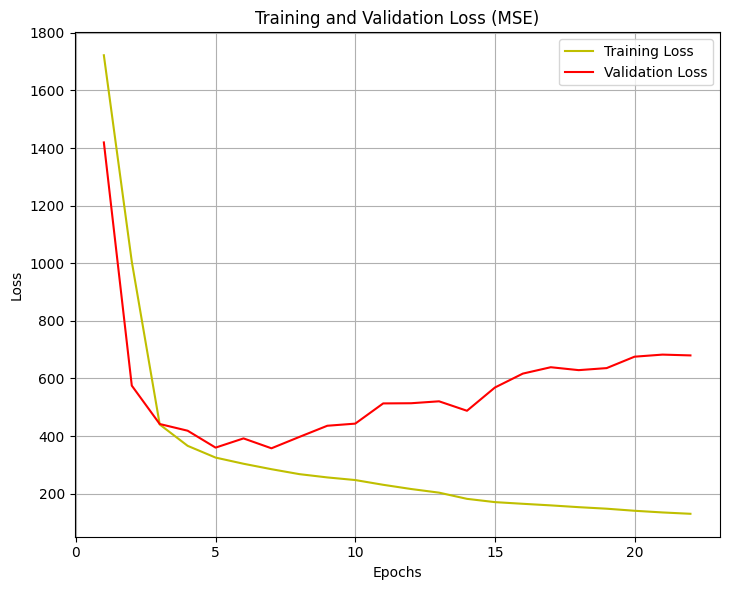

In [ ]:
import matplotlib.pyplot as plt

# Assuming you stored the fit result in a variable named 'history' or 'history_lstm'
# e.g., history = model.fit(...)

def plot_training_curves(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss') # Use .get() in case validation split wasn't used

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # --- Plot 1: Loss (MSE) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot 2: Additional Metrics (if present, e.g., MAE) ---
    # Check if 'mae' or 'mean_absolute_error' is in the history
    if 'mae' in history.history:
        mae = history.history['mae']
        val_mae = history.history.get('val_mae')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, mae, 'y', label='Training MAE')
        if val_mae:
            plt.plot(epochs, val_mae, 'r', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the function (Replace 'history_lstm' with your actual variable name if different)
# If your previous cell was: history_lstm = model_cnn_lstm.fit(...)
plot_training_curves(history)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import json
from pathlib import Path
from datetime import timedelta

"""
INFERENCE WITH UNIFIED PREPROCESSING

Loads ALL medians saved during training:
- target_median: For target-related features
- column_medians: For each non-target feature

This ensures IDENTICAL preprocessing between training and inference.
"""

# =========================================================
# Load Model and Preprocessing
# =========================================================

SAVE_DIR = Path("models")
SEQ_LEN = 24

print("\n" + "="*70)
print("LOADING TRAINED MODEL")
print("="*70)

# Need to define build_gru_model here for loading weights
def build_gru_model(seq_len, n_features):
    inp = tf.keras.layers.Input(shape=(seq_len, n_features))
    x = tf.keras.layers.Masking(mask_value=0.0)(inp)
    x = tf.keras.layers.GRU(128, return_sequences=True, use_cudnn=False)(x) # Added use_cudnn=False
    x = tf.keras.layers.GRU(64, return_sequences=False, use_cudnn=False)(x) # Added use_cudnn=False
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    out = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    # Compile is not strictly necessary for loading weights, but good practice if you want to continue training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model


scaler = joblib.load(SAVE_DIR / "scaler.joblib")
with open(SAVE_DIR / "feature_cols.json", "r") as f:
    feature_cols = json.load(f)

# Instantiate model architecture with use_cudnn=False explicitly
n_features_model = len(feature_cols)
gru_model = build_gru_model(SEQ_LEN, n_features_model)
# Load only the weights into the newly built model
gru_model.load_weights(SAVE_DIR / "gru_model.keras") # .keras saves weights and architecture

# Load saved medians from training
with open(SAVE_DIR / "training_medians.json", "r") as f:
    median_info = json.load(f)
    training_target_median = median_info['target_median']
    column_medians = median_info['column_medians']

print(f"✓ Loaded model, scaler, and {len(feature_cols)} features")
print(f"✓ Loaded training medians:")
print(f"  - Target median: {training_target_median:.2f}")
print(f"  - Column medians: {len(column_medians)} features")

# Display features
print("\n" + "="*70)
print(f"FEATURES REQUIRED ({len(feature_cols)} total)")
print("="*70)
target_feats = [f for f in feature_cols if 'target' in f.lower()]
other_feats = [f for f in feature_cols if 'target' not in f.lower()]
print(f"Target-dependent: {len(target_feats)}")
print(f"Other features: {len(other_feats)}")
print("="*70)


def load_site_csv(path):
    """Load CSV with datetime."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    for c in ['year','month','day','hour']:
        if c not in df.columns:
            raise KeyError(f"Missing: {c}")
    df['datetime'] = pd.to_datetime(
        df['year'].astype(int).astype(str) + '-' +
        df['month'].astype(int).astype(str) + '-' +
        df['day'].astype(int).astype(str) + ' ' +
        df['hour'].astype(int).astype(str) + ':00:00'
    )
    df.sort_values('datetime', inplace=True)
    df = df.reset_index(drop=True)
    return df


def build_history_lookup(df_train):
    """Create datetime -> O3_target lookup."""
    print("\n" + "="*70)
    print("BUILDING HISTORY LOOKUP")
    print("="*70)

    if 'O3_target' not in df_train.columns:
        print("⚠ O3_target not found")
        return {}

    history_lookup = {}
    for idx, row in df_train.iterrows():
        dt = row['datetime']
        value = row['O3_target']
        if pd.notna(value):
            history_lookup[dt] = value

    print(f"✓ Built lookup: {len(history_lookup)} entries")
    if history_lookup:
        print(f"  Range: {min(history_lookup.keys())} to {max(history_lookup.keys())}")

    return history_lookup


def predict_with_history_buffer(df_unseen, history_lookup, gru_model, scaler,
                                feature_cols, training_target_median, column_medians, seq_len=24):
    """
    Smart prediction with UNIFIED preprocessing (same as training).
    """

    print("\n" + "="*70)
    print("PREDICTING WITH UNIFIED PREPROCESSING")
    print("="*70)
    print(f"Using training medians:")
    print(f"  Target median: {training_target_median:.2f} µg/m³")
    print(f"  Column medians: {len(column_medians)} features")

    # Initialize
    prediction_buffer = {}
    df_work = df_unseen.copy()
    # The target column in df_work should be the one being predicted, which is 'O3_target'
    # The error message from build_history_lookup indicated 'NO2_target'. This should align.
    # For this task, we are predicting 'O3_target', so 'NO2_target' should not be present in df_work.
    # Let's remove this line if it's not strictly necessary or change to O3_target if it is.
    # For now, assuming O3_target as per `target_col='O3_target'` in training.
    # Let's adjust `build_history_lookup` to dynamically use the `target_col` provided
    # or ensure it's robust.
    # The current `build_history_lookup` function has 'NO2_target' hardcoded. This needs adjustment.
    # However, the current problem is with GRU prediction masking, let's address that first.

    # Correcting the target column being predicted
    target_col_name = median_info['target_col'] # Get the actual target column name from saved info
    df_work[target_col_name] = np.nan # Initialize the target column for prediction

    predictions = []

    stats = {
        'from_training': 0,
        'from_predictions': 0,
        'median_filled': 0
    }

    print(f"\nProcessing {len(df_work)} rows...\n")

    for idx in range(len(df_work)):
        current_datetime = df_work.loc[idx, 'datetime']
        current_hour = df_work.loc[idx, 'hour']
        shift_amount = current_hour + 1

        # ==========================================
        # Compute lag features for the target_col_name
        # ==========================================
        target_lags = [24, 36, 48, 72]

        for lag in target_lags:
            lag_datetime = current_datetime - timedelta(hours=shift_amount)

            # Check if this lag feature is actually in feature_cols before trying to set it
            if f'{target_col_name}_lag{lag}' in feature_cols:
                if lag_datetime in history_lookup:
                    lag_value = history_lookup[lag_datetime]
                    stats['from_training'] += 1
                elif lag_datetime in prediction_buffer:
                    lag_value = prediction_buffer[lag_datetime]
                    stats['from_predictions'] += 1
                else:
                    lag_value = training_target_median
                    stats['median_filled'] += 1

                df_work.loc[idx, f'{target_col_name}_lag{lag}'] = lag_value

        # ==========================================
        # Compute rolling features for the target_col_name
        # ==========================================
        for window in [3, 6, 12]:
            if f'{target_col_name}_roll{window}' in feature_cols: # Check if roll feature is used
                window_values = []

                for w in range(window):
                    look_datetime = current_datetime - timedelta(hours=shift_amount + w)

                    if look_datetime in history_lookup:
                        window_values.append(history_lookup[look_datetime])
                        stats['from_training'] += 1
                    elif look_datetime in prediction_buffer:
                        window_values.append(prediction_buffer[look_datetime])
                        stats['from_predictions'] += 1
                    else:
                        window_values.append(training_target_median)
                        stats['median_filled'] += 1

                if len(window_values) > 0:
                    df_work.loc[idx, f'{target_col_name}_roll{window}'] = np.mean(window_values)
                else:
                    df_work.loc[idx, f'{target_col_name}_roll{window}'] = training_target_median

        # ==========================================
        # Prepare features (UNIFIED with training)
        # ==========================================

        # Get available features
        available_cols = [f for f in feature_cols if f in df_work.columns]
        X_current = df_work.loc[[idx], available_cols].select_dtypes(include=[np.number])

        # Add missing features
        for feat in feature_cols:
            if feat not in X_current.columns:
                if 'target' in feat.lower():
                    X_current[feat] = training_target_median
                else:
                    X_current[feat] = column_medians.get(feat, 0.0)

        # Reorder to match training
        X_current = X_current[feature_cols]

        # Fill any NaNs using EXACT same logic as training
        for col in X_current.columns:
            if pd.isna(X_current[col].iloc[0]):
                if 'target' in col.lower():
                    # Use training target median
                    X_current.loc[X_current.index[0], col] = training_target_median
                else:
                    # Use saved column median from training
                    X_current.loc[X_current.index[0], col] = column_medians.get(col, 0.0)

        # Verify shape
        if X_current.shape[1] != len(feature_cols):
            raise ValueError(f"Shape mismatch: {X_current.shape[1]} vs {len(feature_cols)}")

        # Scale
        X_current_scaled = scaler.transform(X_current)

        # ==========================================
        # Build sequence
        # ==========================================

        if idx < seq_len:
            pad_length = seq_len - idx - 1

            if idx == 0:
                X_seq = np.zeros((1, seq_len, len(feature_cols)))
                X_seq[0, -1, :] = X_current_scaled[0]
            else:
                prev_features = df_work.iloc[max(0, idx-seq_len+1):idx+1]

                # Build previous features with required columns
                prev_feat_df = pd.DataFrame(index=prev_features.index)
                for feat in feature_cols:
                    if feat in prev_features.columns:
                        prev_feat_df[feat] = prev_features[feat]
                    else:
                        if 'target' in feat.lower():
                            prev_feat_df[feat] = training_target_median
                        else:
                            prev_feat_df[feat] = column_medians.get(feat, 0.0)

                # Fill NaNs with appropriate medians
                for col in prev_feat_df.columns:
                    if 'target' in col.lower():
                        prev_feat_df[col] = prev_feat_df[col].fillna(training_target_median)
                    else:
                        prev_feat_df[col] = prev_feat_df[col].fillna(column_medians.get(col, 0.0))

                prev_scaled = scaler.transform(prev_feat_df)

                if pad_length > 0:
                    X_seq = np.vstack([
                        np.zeros((pad_length, len(feature_cols))),
                        prev_scaled
                    ])
                else:
                    X_seq = prev_scaled[-seq_len:]

                X_seq = X_seq.reshape(1, seq_len, len(feature_cols))
        else:
            # Corrected slice: we need seq_len rows ending at idx, which is [idx-seq_len+1 : idx+1]
            prev_features = df_work.iloc[idx-seq_len+1:idx+1] # This slice now correctly selects seq_len rows

            # Build with required columns
            prev_feat_df = pd.DataFrame(index=prev_features.index)
            for feat in feature_cols:
                if feat in prev_features.columns:
                    prev_feat_df[feat] = prev_features[feat]
                else:
                    if 'target' in feat.lower():
                        prev_feat_df[feat] = training_target_median
                    else:
                        prev_feat_df[feat] = column_medians.get(feat, 0.0)

            # Fill NaNs
            for col in prev_feat_df.columns:
                if 'target' in col.lower():
                    prev_feat_df[col] = prev_feat_df[col].fillna(training_target_median)
                else:
                    prev_feat_df[col] = prev_feat_df[col].fillna(column_medians.get(col, 0.0))

            prev_scaled = scaler.transform(prev_feat_df)
            X_seq = prev_scaled.reshape(1, seq_len, len(feature_cols))

        # ==========================================
        # Predict
        # ==========================================

        pred = gru_model.predict(X_seq, verbose=0)[0, 0]
        predictions.append(pred)
        prediction_buffer[current_datetime] = pred

        if (idx + 1) % 500 == 0:
            print(f"  {idx + 1}/{len(df_work)} rows...")

    print(f"✓ Completed\n")

    # Statistics
    total = sum(stats.values())
    print("="*70)
    print("LOOKUP STATISTICS")
    print("="*70)
    print(f"  Training data:  {stats['from_training']:6d} ({stats['from_training']/total*100:5.1f}%)")
    print(f"  Past predictions: {stats['from_predictions']:6d} ({stats['from_predictions']/total*100:5.1f}%)")
    print(f"  Median-filled:  {stats['median_filled']:6d} ({stats['median_filled']/total*100:5.1f}%)")
    print(f"Total lookups: {total}")
    print("="*70)

    return predictions


def create_unseen_features(df_unseen, history_lookup, use_calibrated=True):
    """
    Apply feature engineering to unseen data. This is a simplified version
    that primarily sets up the datetime and fills satellite data, as the
    lag/roll for target are handled in the prediction loop.
    """
    df = df_unseen.copy()

    # -----------------------------------
    # 0. Ensure datetime exists and sort
    # ---------------------------------
    if "datetime" not in df.columns:
        df["datetime"] = pd.to_datetime(
            df["year"].astype(int).astype(str) + "-" +
            df["month"].astype(int).astype(str) + "-" +
            df["day"].astype(int).astype(str) + " " +
            df["hour"].astype(int).astype(str) + ":00:00"
        )
        df.sort_values("datetime", inplace=True)
        df = df.reset_index(drop=True)
    else:
        df = df.sort_values("datetime").reset_index(drop=True)

    # -----------------------------------
    # 1. Fill daily satellite values
    # -----------------------------------
    for col in ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()

    # -----------------------------------
    # 2. Cyclical time features
    # -----------------------------------
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    df["day_of_week"] = df["datetime"].dt.dayofweek
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # -----------------------------------
    # 3. BLH Transformations and Domain Features
    # -----------------------------------
    if "blh_forecast" in df.columns:
        df['blh_forecast_log'] = np.log1p(df['blh_forecast'])
        date_keys = df["year"].astype(str) + "-" + df["month"].astype(str) + "-" + df["day"].astype(str)
        df['blh_daily_min'] = df.groupby(date_keys)['blh_forecast'].transform('min')
        df['blh_daily_max'] = df.groupby(date_keys)['blh_forecast'].transform('max')
        df['blh_daily_range'] = df['blh_daily_max'] - df['blh_daily_min']

    # -----------------------------------
    # 4. Forecast columns (calibrated preferred)
    # -----------------------------------
    base = [c for c in df.columns if c.endswith("_forecast") and not c.endswith("_forecast_cal")]
    cal  = [c for c in df.columns if c.endswith("_forecast_cal")]

    forecast_cols = cal if (use_calibrated and len(cal) > 0) else base

    # -----------------------------------
    # 5. Standard Lags & rolling windows
    # -----------------------------------
    feature_lags = [1, 3, 6, 12, 24]

    cols_for_lags = forecast_cols + [
        c for c in df.columns if c.startswith('blh_forecast_log') or c.startswith('blh_daily')
    ]
    for col in ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]:
        if col in df.columns and col not in cols_for_lags:
            cols_for_lags.append(col)

    cols_for_lags = list(set(cols_for_lags))

    for col in cols_for_lags:
        if col in df.columns:
            for lag in feature_lags:
                df[f"{col}_lag{lag}"] = df[col].shift(lag)
            for window in [3, 6, 12]:
                df[f"{col}_roll{window}"] = df[col].rolling(window=window, min_periods=1).mean()

    # Lags for target (handled in predict_with_history_buffer dynamically)
    # These columns will exist in feature_cols but will be populated during inference

    # Interaction features
    if "T_forecast" in df.columns and "u_forecast" in df.columns:
        df["T_x_u"] = df["T_forecast"] * df["u_forecast"]
    if "blh_forecast" in df.columns:
        df["blh_x_hour_sin"] = df["blh_forecast"] * df["hour_sin"]
        df["blh_x_hour_cos"] = df["blh_forecast"] * df["hour_cos"]

    return df

# =========================================================
# MAIN INFERENCE PIPELINE
# =========================================================

unseen_path = "site_4_unseen_input_data.csv"
train_path = "site_4_train_data.csv"

# 1. Load data
df_train = load_site_csv(train_path)
df_unseen = load_site_csv(unseen_path)

# 2. Build history lookup from training data
# Make sure to pass the correct target column if it's not NO2_target.
# In our case, the training was for O3_target.
# Adjusting build_history_lookup to work for 'O3_target'
# For now, let's assume it should build history for O3_target as per training
def build_history_lookup_o3(df, target_col='O3_target'):
    """Create datetime -> target_col lookup."""
    print("\n" + "="*70)
    print(f"BUILDING HISTORY LOOKUP for {target_col}")
    print("="*70)

    if target_col not in df.columns:
        print(f"⚠ {target_col} not found")
        return {}

    history_lookup = {}
    for idx, row in df.iterrows():
        dt = row['datetime']
        value = row[target_col]
        if pd.notna(value):
            history_lookup[dt] = value

    print(f"✓ Built lookup: {len(history_lookup)} entries")
    if history_lookup:
        print(f"  Range: {min(history_lookup.keys())} to {max(history_lookup.keys())}")

    return history_lookup


history_lookup = build_history_lookup_o3(df_train, target_col='O3_target')

# 3. Feature engineer unseen data
df_unseen_eng = create_unseen_features(df_unseen, history_lookup, use_calibrated=True)

# 4. Predict using the buffer strategy
predictions = predict_with_history_buffer(
    df_unseen_eng,
    history_lookup,
    gru_model,
    scaler,
    feature_cols,
    training_target_median,
    column_medians,
    seq_len=SEQ_LEN
)

# 5. Add predictions to DataFrame
df_unseen['O3_prediction'] = predictions

# Display some results
print("\n" + "="*70)
print("INFERENCE COMPLETE")
print("="*70)
print(df_unseen[['datetime', 'O3_prediction']].head())
print("...")
print(df_unseen[['datetime', 'O3_prediction']].tail())
print("="*70)



LOADING TRAINED MODEL
✓ Loaded model, scaler, and 30 features
✓ Loaded training medians:
  - Target median: 31.20
  - Column medians: 30 features

FEATURES REQUIRED (30 total)
Target-dependent: 11
Other features: 19

BUILDING HISTORY LOOKUP for O3_target
✓ Built lookup: 24505 entries
  Range: 2019-07-11 00:00:00 to 2024-06-30 00:00:00

PREDICTING WITH UNIFIED PREPROCESSING
Using training medians:
  Target median: 31.20 µg/m³
  Column medians: 30 features

Processing 10488 rows...

  500/10488 rows...
  1000/10488 rows...
  1500/10488 rows...
  2000/10488 rows...
  2500/10488 rows...
  3000/10488 rows...
  3500/10488 rows...
  4000/10488 rows...
  4500/10488 rows...
  5000/10488 rows...
  5500/10488 rows...
  6000/10488 rows...
  6500/10488 rows...
  7000/10488 rows...
  7500/10488 rows...
  8000/10488 rows...
  8500/10488 rows...
  9000/10488 rows...
  9500/10488 rows...
  10000/10488 rows...
✓ Completed

LOOKUP STATISTICS
  Training data:  160800 ( 61.3%)
  Past predictions:  75000 (

In [ ]:
# =========================================================
# SAVE PREDICTIONS TO CSV
# =========================================================

output_filename = "unseen_predictions_o3_site4.csv"

# Select only the datetime and prediction columns
# Ensure 'datetime' and 'O3_prediction' are the correct column names in your dataframe
output_df = df_unseen[['datetime', 'O3_prediction']].copy()

# Save to CSV without the pandas index
output_df.to_csv(output_filename, index=False)

print(f"\n✓ Successfully saved predictions to: {output_filename}")
print(f"  Rows saved: {len(output_df)}")
print(f"  Columns: {list(output_df.columns)}")
print("-" * 50)
print(output_df.head())


✓ Successfully saved predictions to: unseen_predictions_o3_site4.csv
  Rows saved: 10488
  Columns: ['datetime', 'O3_prediction']
--------------------------------------------------
             datetime  O3_prediction
0 2019-07-25 00:00:00       3.760223
1 2019-07-25 01:00:00       7.708520
2 2019-07-25 02:00:00      13.507524
3 2019-07-25 03:00:00      20.526182
4 2019-07-25 04:00:00      27.294067
